In [36]:
from sklearn.linear_model import Lasso
import numpy as np
import pandas as pd

In [51]:
url='https://raw.githubusercontent.com/cathyxinxyz/Capstone_Project_1/master/Datasets/Combined_data_new.csv'
df=pd.read_csv(url,index_col='FIPS',encoding="ISO-8859-1")

In [57]:
from sklearn import preprocessing
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

df=df[df.columns.difference(['State','County','PCT_OBESE_ADULTS13','PCT_DIABETES_ADULTS13'])]

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3143 entries, 1001 to 56045
Data columns (total 62 columns):
CHILDPOVRATE15                       3139 non-null float64
CHIPSTAX_VENDM14                     3143 non-null float64
CONVSPTH14                           3143 non-null float64
Division                             3143 non-null object
FFRPTH14                             3143 non-null float64
FMRKTPTH16                           3143 non-null float64
FOODINSEC_13_15                      3143 non-null float64
FOODINSEC_CHILD_03_11                3143 non-null float64
FOOD_TAX14                           3143 non-null float64
FSRPTH14                             3143 non-null float64
GROCPTH14                            3143 non-null float64
MEDHHINC15                           3139 non-null float64
PCT_18YOUNGER10                      3143 non-null float64
PCT_65OLDER10                        3143 non-null float64
PCT_CACFP15                          3143 non-null float64
PCT_F

In [84]:
df_with_dummy = pd.get_dummies(df, drop_first=True)

In [85]:
df_dropna=df_with_dummy.dropna()

missing value imputation

In [122]:
#pipeline with missing values imputation and regression
# Import the Imputer module
from sklearn.preprocessing import Imputer
# Setup the Imputation transformer: imp
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp_data=imp.fit_transform(df_with_dummy.values)
imp_df=pd.DataFrame(imp_data, index=df_with_dummy.index, columns=df_with_dummy.columns)

In [123]:
normed_data=preprocessing.scale(imp_df)
normed_df=pd.DataFrame(normed_data, index=imp_df.index, columns=imp_df.columns)

normed_data_dropna=preprocessing.scale(df_dropna)
normed_df_nona=pd.DataFrame(normed_data_dropna, index=df_dropna.index, columns=df_dropna.columns)

In [124]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X=normed_df.drop(['prevalence of diabetes', 'prevalence of obesity'], axis=1).values
y=normed_df['prevalence of diabetes'].values

In [129]:
#vary the random state to get best result
l1_space = np.linspace(0, 1, 20)
alpha_space=np.linspace(0.5, 5, 20)

param_grid = {'l1_ratio': l1_space, 'alpha':alpha_space}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

elastic_net = ElasticNet()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=10)

# Fit it to the training data
gm_cv.fit(X_train,y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test,y_test)
mse = mean_squared_error(y_test, y_pred)

print("Tuned parameters: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))


Tuned parameters: {'alpha': 0.050000000000000003, 'l1_ratio': 0.0}
Tuned ElasticNet R squared: 0.7816408955191501
Tuned ElasticNet MSE: 0.22288143414921785


In [130]:
elastic_net = ElasticNet(alpha=0.05, l1_ratio=0)
elastic_net.fit(X_train,y_train)
elastic_net.score(X_test, y_test)

0.78164089551915006

In [138]:
elastic_net = ElasticNet(alpha=0, l1_ratio=0)
elastic_net.fit(X_train,y_train)

ElasticNet(alpha=0, copy_X=True, fit_intercept=True, l1_ratio=0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

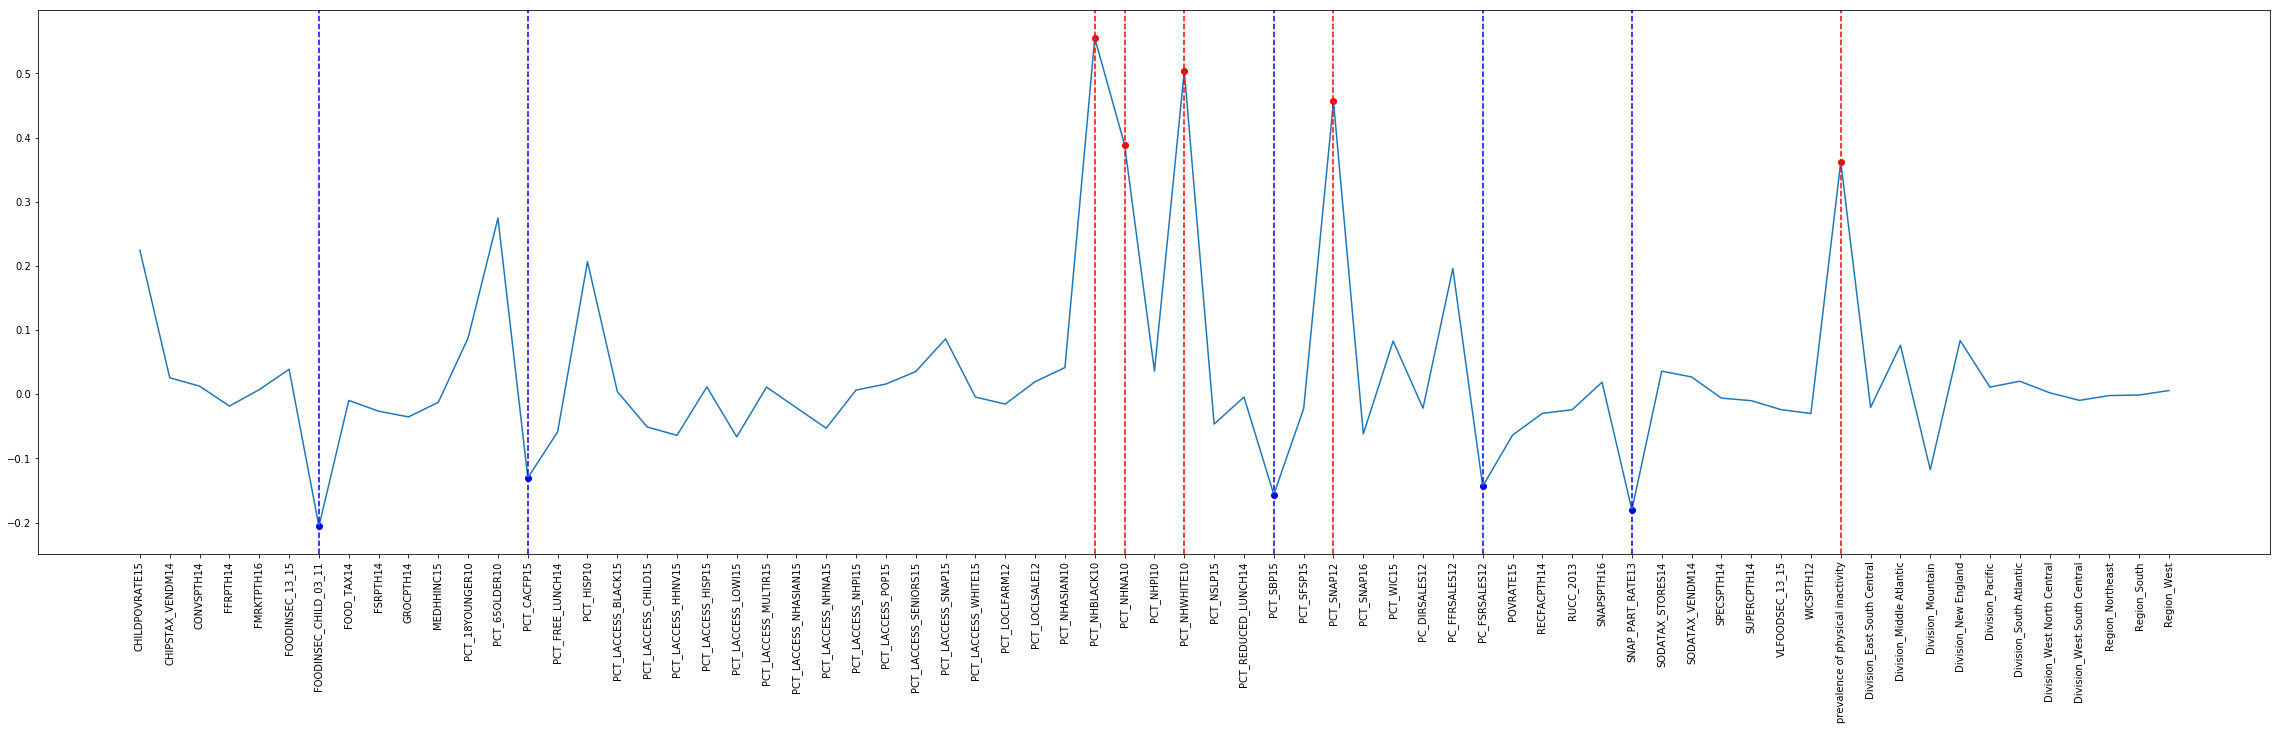

In [139]:
import matplotlib.pyplot as plt
features=normed_df.drop(['prevalence of diabetes', 'prevalence of obesity'], axis=1).columns
plt.figure(figsize=(40,10))
plt.plot(range(len(elastic_net.coef_)), elastic_net.coef_)
Top_five_impactful=sorted([(elastic_net.coef_[i], i) for i in range(len(elastic_net.coef_))], key=lambda tup:tup[0])[-5:]
Top_five_negative=sorted([(elastic_net.coef_[i], i) for i in range(len(elastic_net.coef_))], key=lambda tup:tup[0])[:5]
for i in range(5):
    plt.axvline(x=Top_five_impactful[i][1], linestyle='--', color='r')
    plt.scatter(Top_five_impactful[i][1], Top_five_impactful[i][0], color='r')
for i in range(5):
    plt.axvline(x=Top_five_negative[i][1], linestyle='--', color='b')
    plt.scatter(Top_five_negative[i][1], Top_five_negative[i][0], color='b')
plt.xticks(range(len(elastic_net.coef_)), features, rotation=90)

plt.show()

In [92]:
X_train.shape

(1956, 69)

In [ ]:

X=normed_df.drop(['prevalence of diabetes', 'prevalence of obesity'], axis=1).values
y=normed_df['prevalence of obesity'].values